### The University of Melbourne, School of Computing and Information Systems
# COMP90086 Computer Vision, 2023 Semester 2

## Assignment 1

**Student Name:**    `Tanzid Sultan`

**Student ID:**     `1430660`

This iPython notebook is a template which you should use for your Assignment 1 submission. This file should be submitted at the **Assignment 1** link on the LMS, along with any images needed to run your code.

In addition to this file, you should submit a written report explaining your results at the **Assignment 1** link on the LMS. Please see the assignment specification for details on what must be included in the report for each question.

*Adding proper comments to your code is MANDATORY.*

### 0. Laplacian pyramid compression
You can use the code below to check how much a quantized Laplacian pyramid representation compresses an image.

In [1]:
imSize = 256 # image height/width (assume image is square)
bitsPerLevel = [2,3,4,5,6,7,8] # bits used to encode each level of pyramid

# Image size before compression, in bits (assume uint8 grayscale)
sizeUncompressed = 8 * imSize * imSize
print('Uncompressed size = '+str(sizeUncompressed)+' bits')

# Image size after compression, in bits
sizeCompressed = 0
for i in range(len(bitsPerLevel)):
    sizeCompressed = sizeCompressed + (bitsPerLevel[i]*(imSize/(pow(2,i)))*(imSize/(pow(2,i))))
print('Compressed size = '+str(sizeCompressed)+' bits')

print(str(round(100*sizeCompressed/sizeUncompressed))+'% of original')

Uncompressed size = 524288 bits
Compressed size = 203840.0 bits
39% of original


### 1. Laplacian image pyramid

In [2]:
import numpy as np

# Define the filter kernel
kernel = (1/256)*np.array([[1, 4, 6, 4, 1],
                           [4, 16, 24, 16, 4],
                           [6, 24, 36, 24, 6],
                           [4, 16, 24, 16, 4],
                           [1, 4, 6, 4, 1]])


In [3]:
import cv2
from matplotlib import pyplot as plt

Text(0.5, 1.0, 'filtered image')

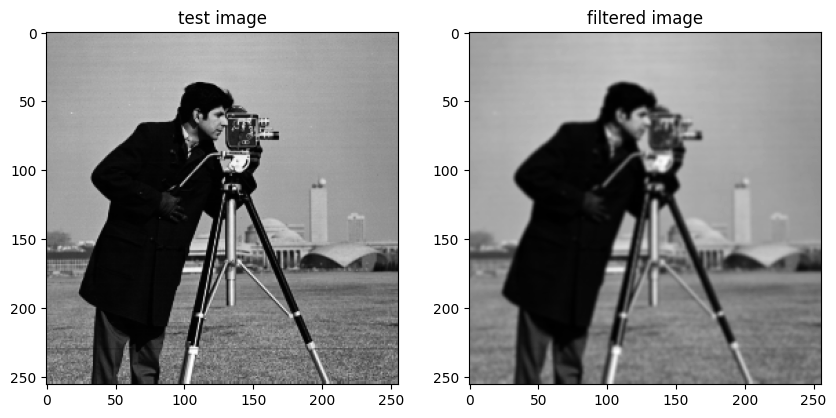

In [8]:
# read in test image as grayscale
test_img = cv2.imread('./cameraman.png', cv2.IMREAD_GRAYSCALE)

# apply filter
filtered_img = cv2.filter2D(test_img, -1, kernel)

plt.figure(figsize=(10,6))

plt.subplot(1,2,1)
plt.imshow(test_img, cmap='gray')
plt.title('test image')

plt.subplot(1,2,2)
plt.imshow(filtered_img, cmap='gray')
plt.title('filtered image')



In [11]:
print(type(test_img))
print(test_img.shape)

<class 'numpy.ndarray'>
(256, 256)


In [15]:
a = np.array([[1,2,3,4], [5,6,7,8], [9,10,11,12], [13,14,15,16]])
b = a[1::2, 1::2]
print(a)
print(b)

[[ 1  2  3  4]
 [ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15 16]]
[[ 6  8]
 [14 16]]


In [48]:
# function for filtereing an image
def filter(I, kernel):
    return cv2.filter2D(I, -1, kernel)


# function for downsampling an image by a factor of 1/2
def downsample(I):
    # keep every other row/column
    D = I[1::2, 1::2]
    return D

# function for upsampling an image by factor of 2
def upsample(I):
    height = I.shape[0] 
    width =  I.shape[1]
    U = np.zeros(shape=(2*height, 2*width))
    # upsampled image will contain zeros on every other row/column
    for i in range(height):
        for j in range(width):
            U[2*i, 2*j] = I[i,j]

    return U        
    
# function for creating a laplace pyramid for an input image
def createLaplacePyramid(I, g, n):
    # list of pyramid images
    L_pyramid = []
    # iterate over pyramid image levels 
    for i in range(n):
        if i < (n-1):
            # filter the image with gaussian kernel
            F = filter(I, g)
            # downsample the filtered image
            D = downsample(F)
            # upsample the image then filter by the gaussian kernel and increase brightness by factor of 4 to compensate for upsampling
            U = filter(upsample(D), 4*g)
            # compute pyramid image for this level
            L = I - U
            L_pyramid.append(L)
            # use downsampled image as input for next level
            I = D
        else:
            # the last level will not be processed any further
            L_pyramid.append(I)    

    return L_pyramid        

# function for reconstructing image from laplace pyramid
def reconstructFromPyramid(L, g):
    n = len(L)
    I = L[-1]
    for i in range(n-2, -1,-1):
        # upsample the pyramid image and apply filter compensated for brightness
        U = filter(upsample(I), 4*g)
        I = U + L[i]

    return I


In [46]:
def plotPyramid(pyramid):
    plt.figure(figsize=(12,6))
    n = len(pyramid)
    for i in range(n):
        plt.subplot(1,n,i+1)
        plt.imshow(pyramid[i], cmap='gray')
        plt.title('L'+ str(i))


Text(0.5, 1.0, 'upsampled+filtered')

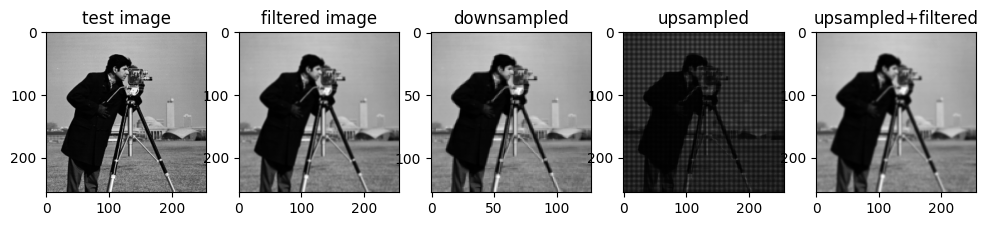

In [39]:
d1 = downsample(filter(test_img, kernel))
u1 = upsample(d1)
f1 = filter(u1, 4*kernel)

plt.figure(figsize=(12,6))

plt.subplot(1,5,1)
plt.imshow(test_img, cmap='gray')
plt.title('test image')

plt.subplot(1,5,2)
plt.imshow(filtered_img, cmap='gray')
plt.title('filtered image')

plt.subplot(1,5,3)
plt.imshow(d1, cmap='gray')
plt.title('downsampled')

plt.subplot(1,5,4)
plt.imshow(u1, cmap='gray')
plt.title('upsampled')

plt.subplot(1,5,5)
plt.imshow(f1, cmap='gray')
plt.title('upsampled+filtered')

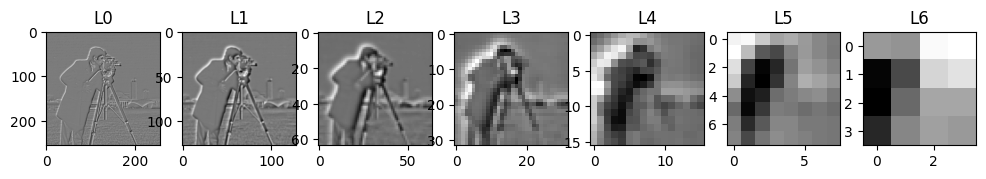

In [47]:
# compute laplace pyramid with 7 levels for the test image
L_pyramid = createLaplacePyramid(test_img, kernel, 7)
plotPyramid(L_pyramid)

Perfect reconstruction: True


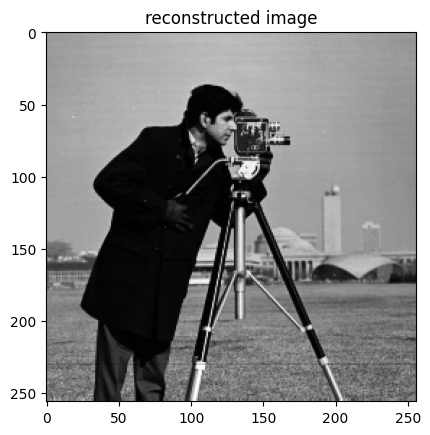

In [53]:
# reconstruct original image from pyramid
rec_img = reconstructFromPyramid(L_pyramid, kernel)

plt.imshow(rec_img, cmap='gray')
plt.title('reconstructed image')

print(f"Perfect reconstruction: {np.array_equal(test_img, rec_img)}")

### 2. Quantization and compression

### 3. Evaluation in the frequency domain